In [94]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers

In [124]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=30

In [96]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
                                                    
)

Found 2152 files belonging to 3 classes.


In [97]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [98]:
len(dataset)
# batches*len(dataset) 32*68=2176
# the last batch is not fully 32

68

(32, 256, 256, 3)


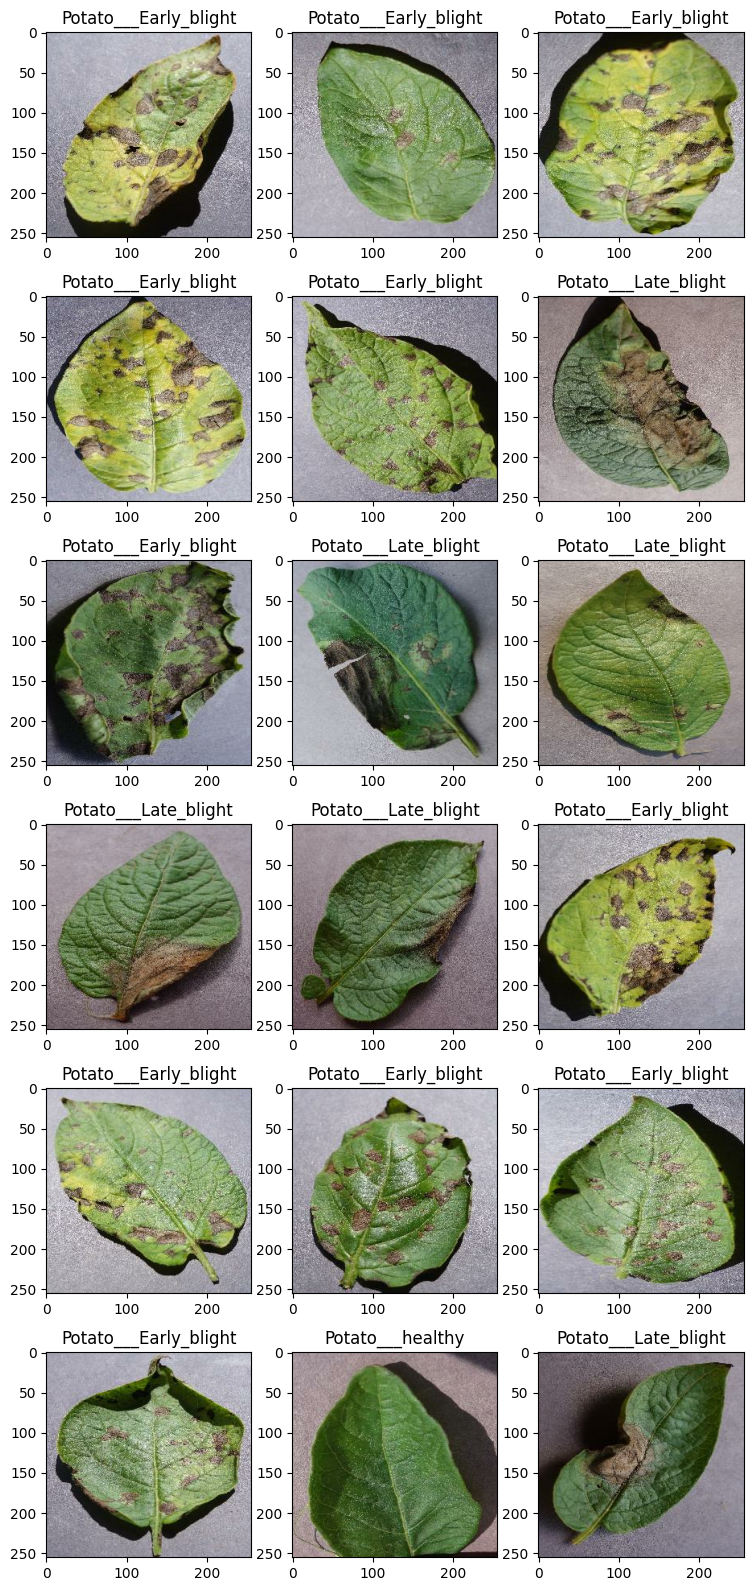

In [99]:
plt.figure(figsize=(9,20))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    for i in range (18):
        plt.subplot(6,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])


In [100]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [101]:
train_ds=dataset.take(54)  # <>out of 68 we took 54 for training.. 
len(train_ds)

54

In [102]:
test_ds=dataset.take(14)
len(test_ds)

14

In [103]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [104]:
# out of 14... 6 is used for validation
val_ds=test_ds.take(6)
len(val_ds)

6

In [105]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [108]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds) #68
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
     
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [109]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [111]:
print(len(train_ds),len(val_ds),len(test_ds))

54 6 8


In [112]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# The below layers will be used in model later

In [113]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [114]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [115]:
# MODEL TRAINING

In [120]:
n_classes=3 # early_blight,late_blight,healthy
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)), # here 3 is channels RGB 
    #             filters(Each filter learns to detect different features),kernelsize, activation func,input_image
    #  higher the filters Start Small: Use a modest number of filters (e.g., 32 or 64) in the initial layers.
    # start small with 32 or 64...Increase Filters in Deeper Layers: As the spatial dimensions of the feature maps decrease (due to pooling or strides), you can afford to increase the number of filters (e.g., 128, 256) to learn more complex patterns.
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(1024,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(1024,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    # tf.keras.layers.Dense is a fully connected (or dense) layer
])

model.build((BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))

In [121]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [123]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [ ]:
history=model.fit(train_ds,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         verbose=1,
         validation_data=val_ds
)

Epoch 1/30
54/54 [==============================] - 255s 5s/step - loss: 0.8864 - accuracy: 0.5214 - val_loss: 0.8068 - val_accuracy: 0.6042
Epoch 2/30
24/54 [============>.................] - ETA: 2:19 - loss: 0.7681 - accuracy: 0.6432

In [ ]:
model.evaluate(test_ds)